# Overview

For the SI, we want to show that changes in the architecture and optimization don't affect the generalization results (other than exact numbers). 

We're going to use DeepHyper to do a hyperparameter optimization over network parameters (specifically, the size of filters, number of filters, filter dilation, batch size, and learning rate). We'll use a specific train-valid-test set split for the hyperparameter search with reduced training time (best model in 150 epochs), and then for final testing of the best model, we'll evaluate using 5-fold cross validation with full training (best model in 250 epochs). 

# Import packages

In [14]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import h5py
import numpy as np
import matplotlib.pyplot as plt
import time
from pandas import DataFrame
import pandas as pd
from routines import *
from skimage import io, transform
import csv
import copy

from deephyper.problem import HpProblem
from deephyper.evaluator import Evaluator
from deephyper.search.hps import CBO
import sklearn

# Model functions

In [11]:
#Model classes
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size1, kernel_size2, dil):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels,out_channels,kernel_size1, padding=dil*(kernel_size1-1)//(2), dilation=dil)
    self.conv2 = nn.Conv2d(out_channels,out_channels,kernel_size2, padding=dil*(kernel_size2-1)//(2), dilation=dil)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.relu1 = nn.ReLU()
    self.relu2 = nn.ReLU()
    self.conv_add = nn.Conv2d(in_channels,out_channels,kernel_size = 1) #Expands/contracts input image in the filter dimension for the ReLU skip connection

    #Copied from torchvision to correctly initialize layers
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight)
      elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
  
  def forward(self, x):
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu1(out)
    out = self.conv2(out)
    out = self.bn2(out)
    skip = self.conv_add(x)
    out += skip
    out = self.relu2(out)
    return out

class UNet(nn.Module): #Adapted from Erin's code
  def __init__(self, num_blocks,filter_num_sequence,filter_size_sequence, dilation_list, num_classes = 2):
    #num_blocks: number of residual blocks in network
    #filter_num_sequence: list of number of filters in each block (length is number of blocks +1)
    #filter_size_sequence: list of the filter sizes for each convolution layer in the block (length is 2*(num_blocks+1))
    #dilation_list: dilation parameter for each block
   
    super(UNet, self).__init__()
    self.downs = nn.ModuleList()
    self.ups = nn.ModuleList()
   
    self.pools = nn.ModuleList()
    self.upsamples = nn.ModuleList()
    

    # creates down and pooling layers
    in_channels = 1
    for i in range(num_blocks):
        self.downs.append(ResidualBlock(in_channels,filter_num_sequence[i],filter_size_sequence[2*i],filter_size_sequence[2*i+1],dilation_list[i]))
        in_channels = filter_num_sequence[i]
        self.pools.append(nn.MaxPool2d(kernel_size = 2, stride = 2))



    # creates up and upsampling layers
    for i in reversed(range(num_blocks)):
        self.ups.append(ResidualBlock(filter_num_sequence[i]+filter_num_sequence[i+1],filter_num_sequence[i],filter_size_sequence[2*i],filter_size_sequence[2*i+1],dilation_list[i])) #The 2*filters in the input channels refers to the extra channels from the concat layer
        self.upsamples.append(nn.Upsample(scale_factor=2))

    # "bottleneck" or middle part at bottom of U
    self.bottleneck = ResidualBlock(filter_num_sequence[num_blocks-1],filter_num_sequence[num_blocks],filter_size_sequence[2*num_blocks],filter_size_sequence[2*num_blocks+1],dilation_list[num_blocks])

    # final convolution with 1x1 kernel
    self.final_conv = nn.Conv2d(filter_num_sequence[0], num_classes, kernel_size = 1)

    self.num_blocks = num_blocks

  
  def forward(self, x):
  
    skips = [] # empty array to store skip connections

    for i in range(self.num_blocks):
        x = self.downs[i](x)
        skips.append(x)
        x = self.pools[i](x)

    x = self.bottleneck(x)
    skips = skips[::-1] # reverse skips array because we want to work with latest one first

    for idx in range(self.num_blocks):
      x = self.upsamples[idx](x)
      skip = skips[idx]
      concat_skip = torch.cat((skip,x),dim=1)
      x = self.ups[idx](concat_skip)

    out = self.final_conv(x)

    return out

class TEMImageDataset_Local_PartialRot(Dataset):
  """Creates a Dataset object that takes in a h5 file with all the training images"""

  def __init__(self, image_dataset, labels_dataset, transform_flag = False):
    """ Args:
      image_filepath (string): path to the h5 file with the images
      img_key (string): the "key" for the images in the h5 file
      labels_filepath (string): path to the h5 file with the maps/labels
      lbl_key (string): the "key" for the labels in the h5 file
      transform (Boolean): whether or not to randomly transform the dataset
    """
    self.image = image_dataset
    self.labels = labels_dataset
    self.transform_flag = transform_flag
  
  def __len__(self):
    return self.image.shape[0]
  
  def __getitem__(self, idx):
    #If the provided idx is a tensor, then convert it to a list
    if torch.is_tensor(idx):
      idx = idx.tolist()
    
    images = self.image[idx] #Note that these output np arrays, not tensors
    labels = self.labels[idx]
    
    if self.transform_flag:
        rot_or_not = torch.rand(1).numpy()
        #Rotate ~50% of the images
        if rot_or_not > 0.5:
            #Determine median bkgd value
            bkgd_val = np.median(images[labels==0])
        
            #Randomly flip and rotate
            rand_vals = torch.rand(2).numpy()
            if rand_vals[0] < 0.33:
                images[0,:,:] = np.flipud(images[0,:,:])
                labels[0,:,:] = np.flipud(labels[0,:,:])
            elif rand_vals[0] < 0.66:
                images[0,:,:] = np.fliplr(images[0,:,:])
                labels[0,:,:] = np.fliplr(labels[0,:,:])
            
            images[0,:,:] = transform.rotate(images[0,:,:],rand_vals[1]*360,mode='constant',cval=bkgd_val)
            labels[0,:,:] = transform.rotate(labels[0,:,:],rand_vals[1]*360,mode='constant',cval=0)
    sample = {'image': images, 'label': labels}
    
    return sample

#Training definitions
def train_loop(dataloader, model, loss_fn, optimizer, device):
  avg_loss = 0
  dice_score = 0
  hard_dice = 0
  size = len(dataloader.dataset)
  model.train()
  for batch_i, sample_batch in enumerate(dataloader):
    #Move the images and labels to the GPU
    images = sample_batch['image'].to(device)
    labels = sample_batch['label'].type(torch.LongTensor).to(device)

    #Compute the prediction (i.e. forward pass)
    pred = model(images)
    
    #Compute the loss
    loss = loss_fn(pred,labels[:,0,:,:]) #can't have dimensions in the channel index

    #Backpropagation
    #First, reset the gradients of the model parameters
    optimizer.zero_grad()
    #Back prop the prediction loss
    loss.backward()
    #Adjust the parameters using the gradients collected
    optimizer.step()

    #Log the loss and dice score
    avg_loss += loss.item()*sample_batch['image'].shape[0] #Undo the normalization by mini-batch size
    dice_score += compute_dice(pred, labels, device).item()
    hard_dice += compute_dice_hard(pred, labels, device).item()

  #After going through all the batches, compute the average loss and dice score
  return avg_loss/size, dice_score/size, hard_dice/size

def test_loop(dataloader, model, loss_fn, optimizer, device):
  avg_loss = 0
  dice_score = 0
  hard_dice = 0
  size = len(dataloader.dataset)
  model.eval()
  with torch.no_grad():
    for batch_i, sample_batch in enumerate(dataloader):
      #Move the images and labels to the GPU
      images = sample_batch['image'].to(device)
      labels = sample_batch['label'].type(torch.LongTensor).to(device)
      #Compute the prediction (i.e. forward pass)
      pred = model(images)
      #Compute the loss
      loss = loss_fn(pred,labels[:,0,:,:]) 
      #Log the loss and dice score
      avg_loss += loss.item()*sample_batch['image'].shape[0] #Undo the normalization by mini-batch size
      dice_score += compute_dice(pred, labels, device).item()
      hard_dice += compute_dice_hard(pred, labels, device).item()

  #After going through all the batches, compute the average loss and dice score
  return avg_loss/size, dice_score/size, hard_dice/size


def compute_dice(y_pred, y_truth, device1, smooth=1):
  #Need to first convert the ground truth into one-hot labels
  #Create a new one_hot tensor on the device
  one_hot = torch.zeros_like(y_pred, device=device1)
  one_hot.scatter_(1,y_truth,1) #first argument is dimension that needs to "expand", second is the indicies to go to, third is the value to place at those locations
  sm_layer = nn.Softmax2d()
  y_pred = sm_layer(y_pred) #normalize the class score
  intersection = torch.sum(y_pred[:,1,:,:] * one_hot[:,1,:,:], dim=(1,2)) #elemental multiplication and then sum, but only for one of the predictions, gives a N-sized tensor
  return torch.sum(torch.div(2. * intersection + smooth , torch.sum(one_hot[:,1,:,:], dim=(1,2)) + torch.sum(y_pred[:,1,:,:],dim=(1,2)) + smooth))

def compute_dice_hard(y_pred, y_truth, device1, smooth=1):
  #Need to first convert the ground truth into one-hot labels
  #Create a new one_hot tensor on the device
  one_hot = torch.zeros_like(y_pred, device=device1)
  one_hot.scatter_(1,y_truth,1) #first argument is dimension that needs to "expand", second is the indicies to go to, third is the value to place at those locations
  sm_layer = nn.Softmax2d()
  y_pred = torch.round(sm_layer(y_pred)) #normalize the class score
  intersection = torch.sum(y_pred[:,1,:,:] * one_hot[:,1,:,:], dim=(1,2)) #elemental multiplication and then sum, but only for one of the predictions, gives a N-sized tensor
  return torch.sum(torch.div(2. * intersection + smooth , torch.sum(one_hot[:,1,:,:], dim=(1,2)) + torch.sum(y_pred[:,1,:,:],dim=(1,2)) + smooth))

def train_model(train_dataset, valid_dataset, b_size, model, loss_fn, optimizer, device, num_epochs):
    
    #Setup the data loader
    train_dataloader = DataLoader(train_dataset, batch_size=b_size, shuffle=True, num_workers=4)
    valid_dataloader = DataLoader(valid_dataset, batch_size=b_size, shuffle=True, num_workers=4)
    
    #Set the logging variable
    #history = {'loss': [], 'dice_coef': [], 'hard_dice_coef': [], 'val_loss': [], 'val_dice_coef': [], 'val_hard_dice_coef': [], 'time': []}
    
    # Only logging loss during hyperparameter search
    history = {'loss': [], 'dice_coef': [], 'hard_dice_coef': [], 'val_loss': [], 'val_dice_coef': [], 'val_hard_dice_coef': [], 'recorded_epoch': []}
    
    #Run the training
    best_loss = 1000
    for t in range(num_epochs):
        start_time=time.time()
        avg_loss, avg_dice, avg_hard_dice = train_loop(train_dataloader, model, loss_fn, optimizer, device)
        history['loss'].append(avg_loss)
        history['dice_coef'].append(avg_dice)
        history['hard_dice_coef'].append(avg_hard_dice)
        val_loss, val_dice, val_hard_dice = test_loop(valid_dataloader, model, loss_fn, optimizer, device)
        history['val_loss'].append(val_loss)
        history['val_dice_coef'].append(val_dice)
        history['val_hard_dice_coef'].append(val_hard_dice)  
        end_time = time.time()
        # Record weights if this is the best model so far
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict()) #Needs to be a copy, otherwise it's just a pointer
            recorded_epoch = t
        history['recorded_epoch'].append(recorded_epoch)
        print('Epoch: '+ str(t) + ' Val Dice: '+str(val_dice) + ' Recorded Epoch: '+str(recorded_epoch)+ ' Time: '+str(end_time-start_time), end='\r')
        
    # Save the best model    
    model.load_state_dict(best_model_state)
    return model, history

def shuffle_Aug_PyTorch(imgs, lbls, seed):
    #Expand dimensions
    img_dataset = np.expand_dims(imgs, axis=3)
    lbl_dataset = np.expand_dims(lbls, axis=3)
    
    #Shuffle and PyTorch format
    img_dataset, lbl_dataset = dihedral_augmentation(img_dataset,lbl_dataset)
    img_dataset, lbl_dataset = shuffle_dataset(img_dataset, lbl_dataset, seed)
    img_dataset = pyTorch_format(img_dataset)
    lbl_dataset = pyTorch_format(lbl_dataset)
    
    return img_dataset, lbl_dataset

def tvt_creation(imgs, lbls, split, seed):
    #Split the dataset
    valid_start = split[0]*imgs.shape[0]//100
    test_start = valid_start + split[1]*imgs.shape[0]//100

    train_dataset = imgs[:valid_start,:,:]
    train_labels = lbls[:valid_start,:,:] 

    valid_dataset = imgs[valid_start:test_start,:,:]
    valid_labels = lbls[valid_start:test_start,:,:]

    test_dataset = imgs[test_start:,:,:]
    test_labels = lbls[test_start:,:,:]

    #print("Size of non-augmented training set: "+ str(train_dataset.shape))
    #print("Size of non-augmented validation set: "+ str(valid_dataset.shape))
    #print("Size of non-augmented test set: "+ str(test_dataset.shape))
    
    #Expand dimensions
    train_dataset = np.expand_dims(train_dataset, axis=3)
    train_labels = np.expand_dims(train_labels, axis=3)

    valid_dataset = np.expand_dims(valid_dataset, axis=3)
    valid_labels = np.expand_dims(valid_labels, axis=3)

    test_dataset = np.expand_dims(test_dataset, axis=3)
    test_labels = np.expand_dims(test_labels, axis=3)
    
    #Augment and Shuffle
    train_dataset, train_labels = dihedral_augmentation(train_dataset,train_labels)
    train_dataset, train_labels = shuffle_dataset(train_dataset, train_labels, seed)

    valid_dataset, valid_labels = dihedral_augmentation(valid_dataset,valid_labels)
    valid_dataset, valid_labels = shuffle_dataset(valid_dataset, valid_labels, seed+1)

    test_dataset, test_labels = dihedral_augmentation(test_dataset,test_labels)
    test_dataset, test_labels = shuffle_dataset(test_dataset, test_labels, seed+10)

    #Convert to PyTorch format
    train_dataset = pyTorch_format(train_dataset)
    train_labels = pyTorch_format(train_labels)

    valid_dataset = pyTorch_format(valid_dataset)
    valid_labels = pyTorch_format(valid_labels)

    test_dataset = pyTorch_format(test_dataset)
    test_labels = pyTorch_format(test_labels)
    
    return train_dataset, train_labels, valid_dataset, valid_labels, test_dataset, test_labels

# DeepHyper Routines

In [59]:
def build_and_train_4blk_model(train_dataset, valid_dataset, configs, seed_num, num_epochs):
    num_blocks = 4
    
    # Set random seed
    torch.manual_seed(seed_num)
    
    # Set default_config dictionary
    default_config = {
        "f1": 3,
        "f2": 3,
        "f3": 3,
        "f4": 3,
        "f5": 3,
        "f6": 3,
        "f7": 3,
        "f8": 3,
        "f9": 3,
        "f10": 3,
        "fnum_start_power": 2,
        "b_size": 32,
        "lr": 1e-4,
        "d1": 1,
        "d2": 1,
        "d3": 1,
        "d4": 1,
        "d5": 1,
    }
    default_config.update(configs)
    print(default_config)
    
    # Define model parameters
    filter_num_sequence = []
    for i in range(num_blocks+1):
        filter_num_sequence.append((2**default_config["fnum_start_power"])*(2**i))
    filter_size_sequence = [default_config["f1"],default_config["f2"],default_config["f3"],default_config["f4"],default_config["f5"],default_config["f6"],default_config["f7"],default_config["f8"],default_config["f9"],default_config["f10"]]
    dilation_list = [default_config["d1"],default_config["d2"],default_config["d3"],default_config["d4"],default_config["d5"]]
    
    # Create model
    model = UNet(num_blocks,filter_num_sequence,filter_size_sequence, dilation_list)
    
    # Define training parameters
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr = default_config["lr"])

    # Setup GPU and move model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    #Make sure batch_size is a python integer
    b_size = default_config["b_size"]
    if not isinstance(b_size, int):
        b_size = b_size.item()
        
    # Train model    
    model, history = train_model(train_dataset, valid_dataset, b_size, model, loss_fn, optimizer, device, num_epochs)
    
    return model, history

def run_2p2nmAu(config):
    # delete previous memory
    torch.cuda.empty_cache()
    
    # create smaller training dataset
    train_img_2p2nm, train_lbl_2p2nm, valid_img_2p2nm, valid_lbl_2p2nm, _, _ = tvt_creation(img_2p2nm, label_2p2nm, [70,10,20], 64277)
    
    train_dataset = TEMImageDataset_Local_PartialRot(train_img_2p2nm, train_lbl_2p2nm, transform_flag = True)
    valid_dataset = TEMImageDataset_Local_PartialRot(valid_img_2p2nm, valid_lbl_2p2nm, transform_flag = False)
    
    print('Train new model')
    model, history = build_and_train_4blk_model(train_dataset, valid_dataset, config, seed_num=45521, num_epochs=150)
    
    #Save the model
    torch.save(model,'DH_4blck_FFCorr2p2nmAu/model_'+str(config["job_id"])+".h5")
    
    # Want to return the value we're trying to maximize
    recorded_epoch = history['recorded_epoch'][-1]
    return -history['val_loss'][recorded_epoch]

def run_5nmAu(config):
    # delete previous memory
    torch.cuda.empty_cache()
    
    # create smaller training dataset
    train_img_5nm, train_lbl_5nm, valid_img_5nm, valid_lbl_5nm, _, _ = tvt_creation(img_5nm, label_5nm, [70,10,20], 64277)
    
    train_dataset = TEMImageDataset_Local_PartialRot(train_img_5nm, train_lbl_5nm, transform_flag = True)
    valid_dataset = TEMImageDataset_Local_PartialRot(valid_img_5nm, valid_lbl_5nm, transform_flag = False)
    
    print('Train new model')
    model, history = build_and_train_4blk_model(train_dataset, valid_dataset, config, seed_num=45521, num_epochs=150)
    
    #Save the model
    torch.save(model,'DH_4blck_FFCorr5nmAu/model_'+str(config["job_id"])+".h5")
    
    # Want to return the value we're trying to maximize
    recorded_epoch = history['recorded_epoch'][-1]
    return -history['val_loss'][recorded_epoch]

def run_10nmAu(config):
    # delete previous memory
    torch.cuda.empty_cache()
    
    # create smaller training dataset
    train_img_10nm, train_lbl_10nm, valid_img_10nm, valid_lbl_10nm, _, _ = tvt_creation(img_10nm, label_10nm, [70,10,20], 64277)
    
    train_dataset = TEMImageDataset_Local_PartialRot(train_img_10nm, train_lbl_10nm, transform_flag = True)
    valid_dataset = TEMImageDataset_Local_PartialRot(valid_img_10nm, valid_lbl_10nm, transform_flag = False)
    
    print('Train new model')
    model, history = build_and_train_4blk_model(train_dataset, valid_dataset, config, seed_num=45521, num_epochs=150)
    
    #Save the model
    torch.save(model,'DH_4blck_FFCorr10nmAu/model_'+str(config["job_id"])+".h5")
    
    # Want to return the value we're trying to maximize
    recorded_epoch = history['recorded_epoch'][-1]
    return -history['val_loss'][recorded_epoch]

# 10nm Hyperparameter search

In [5]:
# Load data
img_filepath = 'Datasets/Flatfield corrected/Au_10nm_330kx_425e_Std_UTC_FFCorr_Team05_Images.h5'
label_filepath = 'Datasets/Flatfield corrected/Au_10nm_330kx_425e_Std_UTC_FFCorr_Team05_Labels.h5'
img_10nm = h5py.File(img_filepath,'r')['images'][:,:,:]
label_10nm = h5py.File(label_filepath,'r')['labels'][:,:,:]

In [21]:
# Define problem
problem = HpProblem()
# Filter size on encoder size varies between [3,5,7] pixels in size
problem.add_hyperparameter([3,5,7],"f1", default_value=3)
problem.add_hyperparameter([3,5,7],"f2", default_value=3)
problem.add_hyperparameter([3,5,7],"f3", default_value=3)
problem.add_hyperparameter([3,5,7],"f4", default_value=3)
problem.add_hyperparameter([3,5,7],"f5", default_value=3)
problem.add_hyperparameter([3,5,7],"f6", default_value=3)
problem.add_hyperparameter([3,5,7],"f7", default_value=3)
problem.add_hyperparameter([3,5,7],"f8", default_value=3)
problem.add_hyperparameter([3,5,7],"f9", default_value=3)
problem.add_hyperparameter([3,5,7],"f10", default_value=3)
#The number of starting filters is either 4, 8, or 16
problem.add_hyperparameter((2,4),"fnum_start_power", default_value=2)
#The batch size ranges from (8,32)
problem.add_hyperparameter((8,32),"b_size", default_value=32)
#The learning rate varies from 1e-6 to 1e-2
problem.add_hyperparameter((1e-6,1e-2, "log-uniform"),"lr", default_value=1e-4)
#The dilation of each block can vary from 1-3
#problem.add_hyperparameter((1,4),"d1", default_value=1) #Don't want to dilate the first block to avoid dilation effects
problem.add_hyperparameter((1,3),"d2", default_value=1)
problem.add_hyperparameter((1,3),"d3", default_value=1)
problem.add_hyperparameter((1,3),"d4", default_value=1)
problem.add_hyperparameter((1,3),"d5", default_value=1)
problem

Configuration space object:
  Hyperparameters:
    b_size, Type: UniformInteger, Range: [8, 32], Default: 32
    d2, Type: UniformInteger, Range: [1, 3], Default: 1
    d3, Type: UniformInteger, Range: [1, 3], Default: 1
    d4, Type: UniformInteger, Range: [1, 3], Default: 1
    d5, Type: UniformInteger, Range: [1, 3], Default: 1
    f1, Type: Ordinal, Sequence: {3, 5, 7}, Default: 3
    f10, Type: Ordinal, Sequence: {3, 5, 7}, Default: 3
    f2, Type: Ordinal, Sequence: {3, 5, 7}, Default: 3
    f3, Type: Ordinal, Sequence: {3, 5, 7}, Default: 3
    f4, Type: Ordinal, Sequence: {3, 5, 7}, Default: 3
    f5, Type: Ordinal, Sequence: {3, 5, 7}, Default: 3
    f6, Type: Ordinal, Sequence: {3, 5, 7}, Default: 3
    f7, Type: Ordinal, Sequence: {3, 5, 7}, Default: 3
    f8, Type: Ordinal, Sequence: {3, 5, 7}, Default: 3
    f9, Type: Ordinal, Sequence: {3, 5, 7}, Default: 3
    fnum_start_power, Type: UniformInteger, Range: [2, 4], Default: 2
    lr, Type: UniformFloat, Range: [1e-06, 0.0

In [22]:
search = CBO(problem, run_10nmAu, initial_points=[problem.default_configuration], log_dir='DH_4blck_FFCorr10nmAu', random_state=619, verbose = 1)
results = search.search(max_evals=20)

Train new model
{'f1': 3, 'f2': 3, 'f3': 3, 'f4': 3, 'f5': 3, 'f6': 3, 'f7': 3, 'f8': 3, 'f9': 3, 'f10': 3, 'fnum_start_power': 2, 'b_size': 32, 'lr': 0.0001, 'd1': 1, 'd2': 1, 'd3': 1, 'd4': 1, 'd5': 1, 'job_id': 1}


  0%|          | 0/20 [00:00<?, ?it/s]

Train new model
{'f1': 7, 'f2': 7, 'f3': 7, 'f4': 5, 'f5': 3, 'f6': 7, 'f7': 3, 'f8': 7, 'f9': 5, 'f10': 3, 'fnum_start_power': 2, 'b_size': 29, 'lr': 0.0047475370194731996, 'd1': 1, 'd2': 1, 'd3': 3, 'd4': 2, 'd5': 2, 'job_id': 2}
Train new modelDice: 0.9009643892447153 Recorded Epoch: 63 Time: 10.049633026123047
{'f1': 5, 'f2': 5, 'f3': 5, 'f4': 7, 'f5': 5, 'f6': 5, 'f7': 7, 'f8': 7, 'f9': 3, 'f10': 3, 'fnum_start_power': 4, 'b_size': 28, 'lr': 0.0006714967793099555, 'd1': 1, 'd2': 1, 'd3': 2, 'd4': 2, 'd5': 3, 'job_id': 3}


ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-20' coro=<Evaluator._execute() done, defined at /home/ksytwu/anaconda3/envs/deephyper/lib/python3.8/site-packages/deephyper/evaluator/_evaluator.py:205> exception=KeyboardInterrupt()>
Traceback (most recent call last):
  File "/home/ksytwu/anaconda3/envs/deephyper/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_765907/1603898186.py", line 2, in <module>
    results = search.search(max_evals=20)
  File "/home/ksytwu/anaconda3/envs/deephyper/lib/python3.8/site-packages/deephyper/search/_search.py", line 131, in search
    self._search(max_evals, timeout)
  File "/home/ksytwu/anaconda3/envs/deephyper/lib/python3.8/site-packages/deephyper/search/hps/_cbo.py", line 252, in _search
    new_results = self._evaluator.gather(self._gather_type, size=1)
  File "/home/ksytwu/anaconda3/envs/deephyper/lib

Train new modelDice: 0.9048627316951752 Recorded Epoch: 7 Time: 20.628998041152954
{'f1': 3, 'f2': 7, 'f3': 5, 'f4': 3, 'f5': 3, 'f6': 3, 'f7': 3, 'f8': 7, 'f9': 3, 'f10': 5, 'fnum_start_power': 4, 'b_size': 13, 'lr': 0.0016788518832355377, 'd1': 1, 'd2': 2, 'd3': 1, 'd4': 3, 'd5': 2, 'job_id': 4}
Train new modelDice: 0.878666952252388 Recorded Epoch: 6 Time: 17.6064345836639404
{'f1': 3, 'f2': 7, 'f3': 7, 'f4': 7, 'f5': 3, 'f6': 5, 'f7': 3, 'f8': 5, 'f9': 5, 'f10': 5, 'fnum_start_power': 3, 'b_size': 18, 'lr': 4.279073139150226e-05, 'd1': 1, 'd2': 1, 'd3': 2, 'd4': 2, 'd5': 1, 'job_id': 5}
Train new modelDice: 0.8678912272055944 Recorded Epoch: 67 Time: 13.862674951553345
{'f1': 3, 'f2': 7, 'f3': 3, 'f4': 5, 'f5': 5, 'f6': 7, 'f7': 5, 'f8': 3, 'f9': 5, 'f10': 3, 'fnum_start_power': 4, 'b_size': 14, 'lr': 2.038345061086991e-05, 'd1': 1, 'd2': 3, 'd3': 3, 'd4': 3, 'd5': 1, 'job_id': 6}
Train new modelDice: 0.8717402319113413 Recorded Epoch: 52 Time: 17.847557544708252
{'f1': 7, 'f2': 5,

From the hyperparameter search, we determine the model with the best performance

In [23]:
results_fpth = 'DH_4blck_FFCorr10nmAu/results.csv'
pd_results = pd.read_csv(results_fpth)
pd_results

,b_size,d2,d3,d4,d5,f1,f10,f2,f3,f4,...,f6,f7,f8,f9,fnum_start_power,lr,job_id,objective,timestamp_submit,timestamp_gather
0,32,1,1,1,1,3,3,3,3,3,...,3,3,3,3,2,0.000100,1,-0.024986,0.048641,741.841862
1,29,1,3,2,2,7,3,7,7,5,...,7,3,7,5,2,0.004748,2,-0.027289,741.939646,2251.439914
2,28,1,2,2,3,5,3,5,5,7,...,5,7,7,3,4,0.000671,3,-0.022688,2251.513060,5351.549919
3,13,2,1,3,2,3,5,7,5,3,...,3,3,7,3,4,0.001679,4,-0.022559,5351.620741,7990.593261
4,18,1,2,2,1,3,5,7,7,7,...,5,3,5,5,3,0.000043,5,-0.025932,7990.666961,10066.865665
5,14,3,3,3,1,3,3,7,3,5,...,7,5,3,5,4,0.000020,6,-0.024364,10066.938604,12745.789243
6,10,3,2,1,1,7,7,5,5,3,...,5,7,3,5,2,0.004959,7,-0.021985,12745.903344,13931.571344
7,21,2,3,1,3,5,3,5,5,7,...,5,3,3,7,3,0.003918,8,-0.022851,13931.643644,15704.799668
8,19,1,2,1,3,3,7,5,7,5,...,3,3,7,5,2,0.000704,9,-0.023669,15704.871406,16873.938682
9,19,2,3,3,2,5,5,3,7,5,...,5,7,3,7,3,0.000252,10,-0.023969,16874.012045,18745.780746


In [24]:
pd_results['objective'].idxmax()

19

The model that had the best performance was model_20

In [36]:
best_config = pd_results.iloc[19].to_dict()
best_config

{'b_size': 27.0,
 'd2': 3.0,
 'd3': 1.0,
 'd4': 1.0,
 'd5': 1.0,
 'f1': 5.0,
 'f10': 7.0,
 'f2': 7.0,
 'f3': 3.0,
 'f4': 5.0,
 'f5': 3.0,
 'f6': 7.0,
 'f7': 5.0,
 'f8': 7.0,
 'f9': 7.0,
 'fnum_start_power': 2.0,
 'lr': 0.004811450712843,
 'job_id': 20.0,
 'objective': -0.0205464306054636,
 'timestamp_submit': 32631.542818069454,
 'timestamp_gather': 34016.56113553047}

Everything except for the learning rate and objective should be converted into integers. 

In [37]:
for key in best_config:
    if key == 'lr':
        continue
    best_config[key]=int(best_config[key])

Next, setup for 5-fold cross validation training

In [38]:
torch.cuda.empty_cache()


k_folds = 5
#Split the dataset and labels into k sub-arrays
imgs_folds = np.array_split(img_10nm, k_folds)
lbls_folds = np.array_split(label_10nm, k_folds)

In [39]:
k_fold_results = {'fold': [], 'train_loss': [], 'train_dice': [], 'train_hard_dice': [], 'valid_loss': [], 'valid_dice': [], 'valid_hard_dice': []}
random_seeds = [962, 1662, 621, 72115, 45521]
fold_size = img_10nm.shape[0]//k_folds

for i in range(k_folds):
    print ('\n Fold #: ', str(i))
    # Create training, validation, and test set for the ith fold
    # Validation set is only used to verify that the model has converged
    copy_imgs_list = imgs_folds.copy()
    copy_lbls_list = lbls_folds.copy()
    test_dataset = copy_imgs_list.pop(i)
    test_lbls = copy_lbls_list.pop(i)
    train_dataset = np.concatenate(copy_imgs_list)
    train_lbls = np.concatenate(copy_lbls_list)
    valid_set_size = int(12.5*train_dataset.shape[0]//100)
    if i != (k_folds-1):
        valid_dataset = train_dataset[i*fold_size:(i*fold_size+valid_set_size),:,:]
        valid_lbls = train_lbls[i*fold_size:(i*fold_size+valid_set_size),:,:]
        train_dataset = np.concatenate((train_dataset[:i*fold_size,:,:],train_dataset[(i*fold_size+valid_set_size):,:,:]))
        train_lbls = np.concatenate((train_lbls[:i*fold_size,:,:],train_lbls[(i*fold_size+valid_set_size):,:,:]))
    else: #if i==k_folds-1
        valid_dataset = train_dataset[(i*fold_size-valid_set_size):,:,:]
        valid_lbls = train_lbls[(i*fold_size-valid_set_size):,:,:]
        train_dataset = train_dataset[:(i*fold_size-valid_set_size),:,:]
        train_lbls = train_lbls[:(i*fold_size-valid_set_size),:,:]
    
    # Augment and shuffle
    train_dataset, train_lbls = shuffle_Aug_PyTorch(train_dataset, train_lbls,9201)
    valid_dataset, valid_lbls = shuffle_Aug_PyTorch(valid_dataset, valid_lbls,6274)
    
    # Setup dataset
    training_dataset = TEMImageDataset_Local_PartialRot(train_dataset,train_lbls, transform_flag = True)
    validation_dataset = TEMImageDataset_Local_PartialRot(valid_dataset,valid_lbls, transform_flag = False)
    
    model, history = build_and_train_4blk_model(training_dataset, validation_dataset, best_config, seed_num=random_seeds[i], num_epochs=250)
    
    torch.save(model, 'DH_4blck_FFCorr10nmAu/Best model/HS_10nmAu_model20_fold'+str(i)+'_seed'+str(random_seeds[i])+'_model.h5')
    history_dataframe = DataFrame(history)
    hist_filename = 'DH_4blck_FFCorr10nmAu/Best model/HS_10nmAu_model20_fold'+str(i)+'_seed'+str(random_seeds[i])+'_trainingLossHistory.csv'
    with open(hist_filename, mode='w') as f:
      history_dataframe.to_csv(f)


 Fold #:  0
{'f1': 5, 'f2': 7, 'f3': 3, 'f4': 5, 'f5': 3, 'f6': 7, 'f7': 5, 'f8': 7, 'f9': 7, 'f10': 7, 'fnum_start_power': 2, 'b_size': 27, 'lr': 0.004811450712843, 'd1': 1, 'd2': 3, 'd3': 1, 'd4': 1, 'd5': 1, 'job_id': 20, 'objective': 0, 'timestamp_submit': 32631, 'timestamp_gather': 34016}
Epoch: 249 Val Dice: 0.9176004926363627 Recorded Epoch: 102 Time: 9.374526500701904
 Fold #:  1
{'f1': 5, 'f2': 7, 'f3': 3, 'f4': 5, 'f5': 3, 'f6': 7, 'f7': 5, 'f8': 7, 'f9': 7, 'f10': 7, 'fnum_start_power': 2, 'b_size': 27, 'lr': 0.004811450712843, 'd1': 1, 'd2': 3, 'd3': 1, 'd4': 1, 'd5': 1, 'job_id': 20, 'objective': 0, 'timestamp_submit': 32631, 'timestamp_gather': 34016}
Epoch: 249 Val Dice: 0.9375443458557129 Recorded Epoch: 32 Time: 9.363639593124396
 Fold #:  2
{'f1': 5, 'f2': 7, 'f3': 3, 'f4': 5, 'f5': 3, 'f6': 7, 'f7': 5, 'f8': 7, 'f9': 7, 'f10': 7, 'fnum_start_power': 2, 'b_size': 27, 'lr': 0.004811450712843, 'd1': 1, 'd2': 3, 'd3': 1, 'd4': 1, 'd5': 1, 'job_id': 20, 'objective': 0, '

# 5nm Hyperparameter Search

In [49]:
# Load data
img_filepath = 'Datasets/Au_5nm_330kx_423e_UTC_Team05_Std_Sess0821FFCorr_Images.h5'
label_filepath = 'Datasets/Au_5nm_330kx_423e_UTC_Team05_Std_Sess0821FFCorr_Labels.h5'
img_5nm = h5py.File(img_filepath,'r')['images'][:,:,:]
label_5nm = h5py.File(label_filepath,'r')['labels'][:,:,:]

In [50]:
# Define problem
problem = HpProblem()
# Filter size on encoder size varies between [3,5,7] pixels in size
problem.add_hyperparameter([3,5,7],"f1", default_value=3)
problem.add_hyperparameter([3,5,7],"f2", default_value=3)
problem.add_hyperparameter([3,5,7],"f3", default_value=3)
problem.add_hyperparameter([3,5,7],"f4", default_value=3)
problem.add_hyperparameter([3,5,7],"f5", default_value=3)
problem.add_hyperparameter([3,5,7],"f6", default_value=3)
problem.add_hyperparameter([3,5,7],"f7", default_value=3)
problem.add_hyperparameter([3,5,7],"f8", default_value=3)
problem.add_hyperparameter([3,5,7],"f9", default_value=3)
problem.add_hyperparameter([3,5,7],"f10", default_value=3)
#The number of starting filters is either 4, 8, or 16
problem.add_hyperparameter((2,4),"fnum_start_power", default_value=2)
#The batch size ranges from (8,32)
problem.add_hyperparameter((8,32),"b_size", default_value=32)
#The learning rate varies from 1e-6 to 1e-2
problem.add_hyperparameter((1e-6,1e-2, "log-uniform"),"lr", default_value=1e-4)
#The dilation of each block can vary from 1-3
#problem.add_hyperparameter((1,4),"d1", default_value=1) #Don't want to dilate the first block to avoid dilation effects
problem.add_hyperparameter((1,3),"d2", default_value=1)
problem.add_hyperparameter((1,3),"d3", default_value=1)
problem.add_hyperparameter((1,3),"d4", default_value=1)
problem.add_hyperparameter((1,3),"d5", default_value=1)
problem

Configuration space object:
  Hyperparameters:
    b_size, Type: UniformInteger, Range: [8, 32], Default: 32
    d2, Type: UniformInteger, Range: [1, 3], Default: 1
    d3, Type: UniformInteger, Range: [1, 3], Default: 1
    d4, Type: UniformInteger, Range: [1, 3], Default: 1
    d5, Type: UniformInteger, Range: [1, 3], Default: 1
    f1, Type: Ordinal, Sequence: {3, 5, 7}, Default: 3
    f10, Type: Ordinal, Sequence: {3, 5, 7}, Default: 3
    f2, Type: Ordinal, Sequence: {3, 5, 7}, Default: 3
    f3, Type: Ordinal, Sequence: {3, 5, 7}, Default: 3
    f4, Type: Ordinal, Sequence: {3, 5, 7}, Default: 3
    f5, Type: Ordinal, Sequence: {3, 5, 7}, Default: 3
    f6, Type: Ordinal, Sequence: {3, 5, 7}, Default: 3
    f7, Type: Ordinal, Sequence: {3, 5, 7}, Default: 3
    f8, Type: Ordinal, Sequence: {3, 5, 7}, Default: 3
    f9, Type: Ordinal, Sequence: {3, 5, 7}, Default: 3
    fnum_start_power, Type: UniformInteger, Range: [2, 4], Default: 2
    lr, Type: UniformFloat, Range: [1e-06, 0.0

In [51]:
search = CBO(problem, run_5nmAu, initial_points=[problem.default_configuration], log_dir='DH_4blck_FFCorr5nmAu', random_state=619, verbose = 1)
results = search.search(max_evals=20)

Train new model
{'f1': 3, 'f2': 3, 'f3': 3, 'f4': 3, 'f5': 3, 'f6': 3, 'f7': 3, 'f8': 3, 'f9': 3, 'f10': 3, 'fnum_start_power': 2, 'b_size': 32, 'lr': 0.0001, 'd1': 1, 'd2': 1, 'd3': 1, 'd4': 1, 'd5': 1, 'job_id': 1}


  0%|          | 0/20 [00:00<?, ?it/s]

Train new model
{'f1': 7, 'f2': 7, 'f3': 7, 'f4': 5, 'f5': 3, 'f6': 7, 'f7': 3, 'f8': 7, 'f9': 5, 'f10': 3, 'fnum_start_power': 2, 'b_size': 29, 'lr': 0.0047475370194731996, 'd1': 1, 'd2': 1, 'd3': 3, 'd4': 2, 'd5': 2, 'job_id': 2}
Train new modelDice: 0.9141295296805245 Recorded Epoch: 32 Time: 16.414578676223755
{'f1': 5, 'f2': 5, 'f3': 5, 'f4': 7, 'f5': 5, 'f6': 5, 'f7': 7, 'f8': 7, 'f9': 3, 'f10': 3, 'fnum_start_power': 4, 'b_size': 28, 'lr': 0.0006714967793099555, 'd1': 1, 'd2': 1, 'd3': 2, 'd4': 2, 'd5': 3, 'job_id': 3}
Train new modelDice: 0.9204498926798502 Recorded Epoch: 19 Time: 33.745455265045166
{'f1': 3, 'f2': 7, 'f3': 5, 'f4': 3, 'f5': 3, 'f6': 3, 'f7': 3, 'f8': 7, 'f9': 3, 'f10': 5, 'fnum_start_power': 4, 'b_size': 13, 'lr': 0.0016788518832355377, 'd1': 1, 'd2': 2, 'd3': 1, 'd4': 3, 'd5': 2, 'job_id': 4}
Train new modelDice: 0.9344023068745931 Recorded Epoch: 16 Time: 28.793557882308962
{'f1': 3, 'f2': 7, 'f3': 7, 'f4': 7, 'f5': 3, 'f6': 5, 'f7': 3, 'f8': 5, 'f9': 5, 'f

In [52]:
# Look at the hyperparameter results
results_fpth = 'DH_4blck_FFCorr5nmAu/results.csv'
pd_results = pd.read_csv(results_fpth)
pd_results

,b_size,d2,d3,d4,d5,f1,f10,f2,f3,f4,...,f6,f7,f8,f9,fnum_start_power,lr,job_id,objective,timestamp_submit,timestamp_gather
0,32,1,1,1,1,3,3,3,3,3,...,3,3,3,3,2,0.000100,1,-0.057214,0.056976,1185.381039
1,29,1,3,2,2,7,3,7,7,5,...,7,3,7,5,2,0.004748,2,-0.052455,1185.467112,3650.467745
2,28,1,2,2,3,5,3,5,5,7,...,5,7,7,3,4,0.000671,3,-0.052315,3650.540803,8719.230972
3,13,2,1,3,2,3,5,7,5,3,...,3,3,7,3,4,0.001679,4,-0.052578,8719.303082,13052.066257
4,18,1,2,2,1,3,5,7,7,7,...,5,3,5,5,3,0.000043,5,-0.054144,13052.140193,16454.838094
5,14,3,3,3,1,3,3,7,3,5,...,7,5,3,5,4,0.000020,6,-0.056323,16454.968064,20848.168832
6,10,3,2,1,1,7,7,5,5,3,...,5,7,3,5,2,0.004959,7,-0.048096,20848.241011,22777.132000
7,21,2,3,1,3,5,3,5,5,7,...,5,3,3,7,3,0.003918,8,-0.056332,22777.206938,25659.741110
8,19,1,2,1,3,3,7,5,7,5,...,3,3,7,5,2,0.000704,9,-0.057955,25659.815101,27541.968340
9,19,2,3,3,2,5,5,3,7,5,...,5,7,3,7,3,0.000252,10,-0.053932,27542.082864,30594.550297


In [53]:
pd_results['objective'].idxmax()

6

In [54]:
best_config = pd_results.iloc[6].to_dict()
for key in best_config:
    if key == 'lr':
        continue
    best_config[key]=int(best_config[key])
best_config

{'b_size': 10,
 'd2': 3,
 'd3': 2,
 'd4': 1,
 'd5': 1,
 'f1': 7,
 'f10': 7,
 'f2': 5,
 'f3': 5,
 'f4': 3,
 'f5': 7,
 'f6': 5,
 'f7': 7,
 'f8': 3,
 'f9': 5,
 'fnum_start_power': 2,
 'lr': 0.0049589948633369,
 'job_id': 7,
 'objective': 0,
 'timestamp_submit': 20848,
 'timestamp_gather': 22777}

Train using the best_model parameters

In [55]:
torch.cuda.empty_cache()

k_folds = 5
#Split the dataset and labels into k sub-arrays
imgs_folds = np.array_split(img_5nm, k_folds)
lbls_folds = np.array_split(label_5nm, k_folds)

In [56]:
random_seeds = [962, 1662, 621, 72115, 45521]
fold_size = img_5nm.shape[0]//k_folds

for i in range(k_folds):
    print ('\n Fold #: ', str(i))
    # Create training, validation, and test set for the ith fold
    # Validation set is only used to verify that the model has converged
    copy_imgs_list = imgs_folds.copy()
    copy_lbls_list = lbls_folds.copy()
    test_dataset = copy_imgs_list.pop(i)
    test_lbls = copy_lbls_list.pop(i)
    train_dataset = np.concatenate(copy_imgs_list)
    train_lbls = np.concatenate(copy_lbls_list)
    valid_set_size = int(12.5*train_dataset.shape[0]//100)
    if i != (k_folds-1):
        valid_dataset = train_dataset[i*fold_size:(i*fold_size+valid_set_size),:,:]
        valid_lbls = train_lbls[i*fold_size:(i*fold_size+valid_set_size),:,:]
        train_dataset = np.concatenate((train_dataset[:i*fold_size,:,:],train_dataset[(i*fold_size+valid_set_size):,:,:]))
        train_lbls = np.concatenate((train_lbls[:i*fold_size,:,:],train_lbls[(i*fold_size+valid_set_size):,:,:]))
    else: #if i==k_folds-1
        valid_dataset = train_dataset[(i*fold_size-valid_set_size):,:,:]
        valid_lbls = train_lbls[(i*fold_size-valid_set_size):,:,:]
        train_dataset = train_dataset[:(i*fold_size-valid_set_size),:,:]
        train_lbls = train_lbls[:(i*fold_size-valid_set_size),:,:]
    
    # Augment and shuffle
    train_dataset, train_lbls = shuffle_Aug_PyTorch(train_dataset, train_lbls,9201)
    valid_dataset, valid_lbls = shuffle_Aug_PyTorch(valid_dataset, valid_lbls,6274)
    
    # Setup dataset
    training_dataset = TEMImageDataset_Local_PartialRot(train_dataset,train_lbls, transform_flag = True)
    validation_dataset = TEMImageDataset_Local_PartialRot(valid_dataset,valid_lbls, transform_flag = False)
    
    model, history = build_and_train_4blk_model(training_dataset, validation_dataset, best_config, seed_num=random_seeds[i], num_epochs=250)
    
    torch.save(model, 'DH_4blck_FFCorr5nmAu/Best model/HS_5nmAu_model7_fold'+str(i)+'_seed'+str(random_seeds[i])+'_model.h5')
    history_dataframe = DataFrame(history)
    hist_filename = 'DH_4blck_FFCorr5nmAu/Best model/HS_5nmAu_model7_fold'+str(i)+'_seed'+str(random_seeds[i])+'_trainingLossHistory.csv'
    with open(hist_filename, mode='w') as f:
      history_dataframe.to_csv(f)


 Fold #:  0
{'f1': 7, 'f2': 5, 'f3': 5, 'f4': 3, 'f5': 7, 'f6': 5, 'f7': 7, 'f8': 3, 'f9': 5, 'f10': 7, 'fnum_start_power': 2, 'b_size': 10, 'lr': 0.0049589948633369, 'd1': 1, 'd2': 3, 'd3': 2, 'd4': 1, 'd5': 1, 'job_id': 7, 'objective': 0, 'timestamp_submit': 20848, 'timestamp_gather': 22777}
Epoch: 249 Val Dice: 0.8831038815634591 Recorded Epoch: 27 Time: 12.801949024200444
 Fold #:  1
{'f1': 7, 'f2': 5, 'f3': 5, 'f4': 3, 'f5': 7, 'f6': 5, 'f7': 7, 'f8': 3, 'f9': 5, 'f10': 7, 'fnum_start_power': 2, 'b_size': 10, 'lr': 0.0049589948633369, 'd1': 1, 'd2': 3, 'd3': 2, 'd4': 1, 'd5': 1, 'job_id': 7, 'objective': 0, 'timestamp_submit': 20848, 'timestamp_gather': 22777}
Epoch: 249 Val Dice: 0.9140743868691581 Recorded Epoch: 61 Time: 12.886886358261108
 Fold #:  2
{'f1': 7, 'f2': 5, 'f3': 5, 'f4': 3, 'f5': 7, 'f6': 5, 'f7': 7, 'f8': 3, 'f9': 5, 'f10': 7, 'fnum_start_power': 2, 'b_size': 10, 'lr': 0.0049589948633369, 'd1': 1, 'd2': 3, 'd3': 2, 'd4': 1, 'd5': 1, 'job_id': 7, 'objective': 0, 

# 2.2nm Hyperparameter Search

In [57]:
# Load data
img_filepath = 'Datasets/Flatfield corrected/Au_2p2nm_330kx_423e_Std_UTC_FFCorr_Team05_Images.h5'
label_filepath = 'Datasets/Flatfield corrected/Au_2p2nm_330kx_423e_Std_UTC_FFCorr_Team05_Labels.h5'
img_2p2nm = h5py.File(img_filepath,'r')['images'][:,:,:]
label_2p2nm = h5py.File(label_filepath,'r')['labels'][:,:,:]

In [58]:
# Define problem
problem = HpProblem()
# Filter size on encoder size varies between [3,5,7] pixels in size
problem.add_hyperparameter([3,5,7],"f1", default_value=3)
problem.add_hyperparameter([3,5,7],"f2", default_value=3)
problem.add_hyperparameter([3,5,7],"f3", default_value=3)
problem.add_hyperparameter([3,5,7],"f4", default_value=3)
problem.add_hyperparameter([3,5,7],"f5", default_value=3)
problem.add_hyperparameter([3,5,7],"f6", default_value=3)
problem.add_hyperparameter([3,5,7],"f7", default_value=3)
problem.add_hyperparameter([3,5,7],"f8", default_value=3)
problem.add_hyperparameter([3,5,7],"f9", default_value=3)
problem.add_hyperparameter([3,5,7],"f10", default_value=3)
#The number of starting filters is either 4, 8, or 16
problem.add_hyperparameter((2,4),"fnum_start_power", default_value=2)
#The batch size ranges from (8,32)
problem.add_hyperparameter((8,32),"b_size", default_value=32)
#The learning rate varies from 1e-6 to 1e-2
problem.add_hyperparameter((1e-6,1e-2, "log-uniform"),"lr", default_value=1e-4)
#The dilation of each block can vary from 1-3
#problem.add_hyperparameter((1,4),"d1", default_value=1) #Don't want to dilate the first block to avoid dilation effects
problem.add_hyperparameter((1,3),"d2", default_value=1)
problem.add_hyperparameter((1,3),"d3", default_value=1)
problem.add_hyperparameter((1,3),"d4", default_value=1)
problem.add_hyperparameter((1,3),"d5", default_value=1)
problem

Configuration space object:
  Hyperparameters:
    b_size, Type: UniformInteger, Range: [8, 32], Default: 32
    d2, Type: UniformInteger, Range: [1, 3], Default: 1
    d3, Type: UniformInteger, Range: [1, 3], Default: 1
    d4, Type: UniformInteger, Range: [1, 3], Default: 1
    d5, Type: UniformInteger, Range: [1, 3], Default: 1
    f1, Type: Ordinal, Sequence: {3, 5, 7}, Default: 3
    f10, Type: Ordinal, Sequence: {3, 5, 7}, Default: 3
    f2, Type: Ordinal, Sequence: {3, 5, 7}, Default: 3
    f3, Type: Ordinal, Sequence: {3, 5, 7}, Default: 3
    f4, Type: Ordinal, Sequence: {3, 5, 7}, Default: 3
    f5, Type: Ordinal, Sequence: {3, 5, 7}, Default: 3
    f6, Type: Ordinal, Sequence: {3, 5, 7}, Default: 3
    f7, Type: Ordinal, Sequence: {3, 5, 7}, Default: 3
    f8, Type: Ordinal, Sequence: {3, 5, 7}, Default: 3
    f9, Type: Ordinal, Sequence: {3, 5, 7}, Default: 3
    fnum_start_power, Type: UniformInteger, Range: [2, 4], Default: 2
    lr, Type: UniformFloat, Range: [1e-06, 0.0

In [60]:
search = CBO(problem, run_2p2nmAu, initial_points=[problem.default_configuration], log_dir='DH_4blck_FFCorr2p2nmAu', random_state=619, verbose = 1)
results = search.search(max_evals=20)

Train new model
{'f1': 3, 'f2': 3, 'f3': 3, 'f4': 3, 'f5': 3, 'f6': 3, 'f7': 3, 'f8': 3, 'f9': 3, 'f10': 3, 'fnum_start_power': 2, 'b_size': 32, 'lr': 0.0001, 'd1': 1, 'd2': 1, 'd3': 1, 'd4': 1, 'd5': 1, 'job_id': 1}


  0%|          | 0/20 [00:00<?, ?it/s]

Train new model
{'f1': 7, 'f2': 7, 'f3': 7, 'f4': 5, 'f5': 3, 'f6': 7, 'f7': 3, 'f8': 7, 'f9': 5, 'f10': 3, 'fnum_start_power': 2, 'b_size': 29, 'lr': 0.0047475370194731996, 'd1': 1, 'd2': 1, 'd3': 3, 'd4': 2, 'd5': 2, 'job_id': 2}
Train new modelDice: 0.8085236242839269 Recorded Epoch: 16 Time: 26.957619667053223
{'f1': 5, 'f2': 5, 'f3': 5, 'f4': 7, 'f5': 5, 'f6': 5, 'f7': 7, 'f8': 7, 'f9': 3, 'f10': 3, 'fnum_start_power': 4, 'b_size': 28, 'lr': 0.0006714967793099555, 'd1': 1, 'd2': 1, 'd3': 2, 'd4': 2, 'd5': 3, 'job_id': 3}
Train new modelDice: 0.8269510269165039 Recorded Epoch: 14 Time: 56.444686651229866
{'f1': 3, 'f2': 7, 'f3': 5, 'f4': 3, 'f5': 3, 'f6': 3, 'f7': 3, 'f8': 7, 'f9': 3, 'f10': 5, 'fnum_start_power': 4, 'b_size': 13, 'lr': 0.0016788518832355377, 'd1': 1, 'd2': 2, 'd3': 1, 'd4': 3, 'd5': 2, 'job_id': 4}
Train new modelDice: 0.8308690701212201 Recorded Epoch: 9 Time: 48.092008829116824
{'f1': 3, 'f2': 7, 'f3': 7, 'f4': 7, 'f5': 3, 'f6': 5, 'f7': 3, 'f8': 5, 'f9': 5, 'f1

In [62]:
# Look at the hyperparameter results
results_fpth = 'DH_4blck_FFCorr2p2nmAu/results.csv'
pd_results = pd.read_csv(results_fpth)
pd_results

,b_size,d2,d3,d4,d5,f1,f10,f2,f3,f4,...,f6,f7,f8,f9,fnum_start_power,lr,job_id,objective,timestamp_submit,timestamp_gather
0,32,1,1,1,1,3,3,3,3,3,...,3,3,3,3,2,0.000100,1,-0.136353,0.102057,1914.577240
1,29,1,3,2,2,7,3,7,7,5,...,7,3,7,5,2,0.004748,2,-0.131542,1914.661771,5963.595301
2,28,1,2,2,3,5,3,5,5,7,...,5,7,7,3,4,0.000671,3,-0.123530,5963.665889,14438.125714
3,13,2,1,3,2,3,5,7,5,3,...,3,3,7,3,4,0.001679,4,-0.126462,14438.200419,21657.024977
4,18,1,2,2,1,3,5,7,7,7,...,5,3,5,5,3,0.000043,5,-0.132125,21657.137813,27307.750620
5,14,3,3,3,1,3,3,7,3,5,...,7,5,3,5,4,0.000020,6,-0.133496,27307.824622,34641.335759
6,10,3,2,1,1,7,7,5,5,3,...,5,7,3,5,2,0.004959,7,-0.129103,34641.406919,37840.172969
7,21,2,3,1,3,5,3,5,5,7,...,5,3,3,7,3,0.003918,8,-0.129887,37840.288701,42633.424608
8,19,1,2,1,3,3,7,5,7,5,...,3,3,7,5,2,0.000704,9,-0.132395,42633.497839,45763.027089
9,19,2,3,3,2,5,5,3,7,5,...,5,7,3,7,3,0.000252,10,-0.129984,45763.098398,50841.741928


In [63]:
pd_results['objective'].idxmax()

2

In [64]:
best_config = pd_results.iloc[2].to_dict()
for key in best_config:
    if key == 'lr':
        continue
    best_config[key]=int(best_config[key])
best_config

{'b_size': 28,
 'd2': 1,
 'd3': 2,
 'd4': 2,
 'd5': 3,
 'f1': 5,
 'f10': 3,
 'f2': 5,
 'f3': 5,
 'f4': 7,
 'f5': 5,
 'f6': 5,
 'f7': 7,
 'f8': 7,
 'f9': 3,
 'fnum_start_power': 4,
 'lr': 0.0006714967793099,
 'job_id': 3,
 'objective': 0,
 'timestamp_submit': 5963,
 'timestamp_gather': 14438}

In [65]:
torch.cuda.empty_cache()

k_folds = 5
#Split the dataset and labels into k sub-arrays
imgs_folds = np.array_split(img_2p2nm, k_folds)
lbls_folds = np.array_split(label_2p2nm, k_folds)

In [67]:
random_seeds = [962, 1662, 621, 72115, 45521]
fold_size = img_2p2nm.shape[0]//k_folds

for i in range(k_folds):
    print ('\n Fold #: ', str(i))
    # Create training, validation, and test set for the ith fold
    # Validation set is only used to verify that the model has converged
    copy_imgs_list = imgs_folds.copy()
    copy_lbls_list = lbls_folds.copy()
    test_dataset = copy_imgs_list.pop(i)
    test_lbls = copy_lbls_list.pop(i)
    train_dataset = np.concatenate(copy_imgs_list)
    train_lbls = np.concatenate(copy_lbls_list)
    valid_set_size = int(12.5*train_dataset.shape[0]//100)
    if i != (k_folds-1):
        valid_dataset = train_dataset[i*fold_size:(i*fold_size+valid_set_size),:,:]
        valid_lbls = train_lbls[i*fold_size:(i*fold_size+valid_set_size),:,:]
        train_dataset = np.concatenate((train_dataset[:i*fold_size,:,:],train_dataset[(i*fold_size+valid_set_size):,:,:]))
        train_lbls = np.concatenate((train_lbls[:i*fold_size,:,:],train_lbls[(i*fold_size+valid_set_size):,:,:]))
    else: #if i==k_folds-1
        valid_dataset = train_dataset[(i*fold_size-valid_set_size):,:,:]
        valid_lbls = train_lbls[(i*fold_size-valid_set_size):,:,:]
        train_dataset = train_dataset[:(i*fold_size-valid_set_size),:,:]
        train_lbls = train_lbls[:(i*fold_size-valid_set_size),:,:]
    
    # Augment and shuffle
    train_dataset, train_lbls = shuffle_Aug_PyTorch(train_dataset, train_lbls,9201)
    valid_dataset, valid_lbls = shuffle_Aug_PyTorch(valid_dataset, valid_lbls,6274)
    
    # Setup dataset
    training_dataset = TEMImageDataset_Local_PartialRot(train_dataset,train_lbls, transform_flag = True)
    validation_dataset = TEMImageDataset_Local_PartialRot(valid_dataset,valid_lbls, transform_flag = False)
    
    model, history = build_and_train_4blk_model(training_dataset, validation_dataset, best_config, seed_num=random_seeds[i], num_epochs=250)
    
    torch.save(model, 'DH_4blck_FFCorr2p2nmAu/Best model/HS_2p2nmAu_model3_fold'+str(i)+'_seed'+str(random_seeds[i])+'_model.h5')
    history_dataframe = DataFrame(history)
    hist_filename = 'DH_4blck_FFCorr2p2nmAu/Best model/HS_2p2nmAu_model3_fold'+str(i)+'_seed'+str(random_seeds[i])+'_trainingLossHistory.csv'
    with open(hist_filename, mode='w') as f:
      history_dataframe.to_csv(f)


 Fold #:  0
{'f1': 5, 'f2': 5, 'f3': 5, 'f4': 7, 'f5': 5, 'f6': 5, 'f7': 7, 'f8': 7, 'f9': 3, 'f10': 3, 'fnum_start_power': 4, 'b_size': 28, 'lr': 0.0006714967793099, 'd1': 1, 'd2': 1, 'd3': 2, 'd4': 2, 'd5': 3, 'job_id': 3, 'objective': 0, 'timestamp_submit': 5963, 'timestamp_gather': 14438}
Epoch: 249 Val Dice: 0.798912593296596 Recorded Epoch: 10 Time: 56.7891571521759236
 Fold #:  1
{'f1': 5, 'f2': 5, 'f3': 5, 'f4': 7, 'f5': 5, 'f6': 5, 'f7': 7, 'f8': 7, 'f9': 3, 'f10': 3, 'fnum_start_power': 4, 'b_size': 28, 'lr': 0.0006714967793099, 'd1': 1, 'd2': 1, 'd3': 2, 'd4': 2, 'd5': 3, 'job_id': 3, 'objective': 0, 'timestamp_submit': 5963, 'timestamp_gather': 14438}
Epoch: 249 Val Dice: 0.7874542168208531 Recorded Epoch: 9 Time: 57.048395156860355
 Fold #:  2
{'f1': 5, 'f2': 5, 'f3': 5, 'f4': 7, 'f5': 5, 'f6': 5, 'f7': 7, 'f8': 7, 'f9': 3, 'f10': 3, 'fnum_start_power': 4, 'b_size': 28, 'lr': 0.0006714967793099, 'd1': 1, 'd2': 1, 'd3': 2, 'd4': 2, 'd5': 3, 'job_id': 3, 'objective': 0, 'ti

# Testing hyperparameter models

In [70]:
def test_sim(model_filepath_start, dataset, labels, save_fpath):
    # Split up into k=5 folds
    k_fold_results = {'fold': [], 'test_loss': [], 'test_dice': [], 'test_hard_dice': []}
    k_folds = 5
    random_seeds = [962, 1662, 621, 72115, 45521]
    imgs_folds = np.array_split(dataset, k_folds)
    lbls_folds = np.array_split(labels, k_folds)
    
    for i in range(k_folds): # For every k-fold model
        # Grab test set
        test_dataset = imgs_folds[i]
        test_lbls = lbls_folds[i]
        test_dataset, test_lbls = shuffle_Aug_PyTorch(test_dataset, test_lbls,7427)
        
        # Load model
        seed_num = random_seeds[i]
        model_filepath = model_filepath_start+str(i)+'_seed'+str(seed_num)+'_model.h5'
        model = torch.load(model_filepath)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.to(device)
        b_size = 32
        loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(),lr = 1e-4)
        
        # Run test set through model
        test_loss, test_dice, test_hard_dice = test_model(model, test_dataset, test_lbls, device, b_size, loss_fn, optimizer)
        
        # Record values
        k_fold_results['fold'].append(i)
        k_fold_results['test_loss'].append(test_loss)
        k_fold_results['test_dice'].append(test_dice)
        k_fold_results['test_hard_dice'].append(test_hard_dice)
    
    # Save csv
    results_dataframe = DataFrame(k_fold_results)
    with open(save_fpath, mode='w') as f:
        results_dataframe.to_csv(f)
    
    avg_loss = np.mean(k_fold_results['test_loss'])
    std_loss = np.std(k_fold_results['test_loss'])
    avg_hd = np.mean(k_fold_results['test_hard_dice'])
    std_hd = np.std(k_fold_results['test_hard_dice'])
    
    return avg_loss, std_loss, avg_hd, std_hd

def test_diff(model_filepath_start, dataset, labels, save_fpath):
    k_folds = 5
    k_fold_results = {'fold': [], 'test_loss': [], 'test_dice': [], 'test_hard_dice': []}
    random_seeds = [962, 1662, 621, 72115, 45521]
    
    # Same dataset for every k-fold model
    test_dataset, test_lbls = shuffle_Aug_PyTorch(dataset, labels, 7427)
    
    for i in range(k_folds): # For every k-fold model
        # Load model
        seed_num = random_seeds[i]
        model_filepath = model_filepath_start+str(i)+'_seed'+str(seed_num)+'_model.h5'
        model = torch.load(model_filepath)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.to(device)
        b_size = 32
        loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(),lr = 1e-4)
        
        # Run test set through model
        test_loss, test_dice, test_hard_dice = test_model(model, test_dataset, test_lbls, device, b_size, loss_fn, optimizer)
        
        # Record values
        k_fold_results['fold'].append(i)
        k_fold_results['test_loss'].append(test_loss)
        k_fold_results['test_dice'].append(test_dice)
        k_fold_results['test_hard_dice'].append(test_hard_dice)
   
    # Save csv
    results_dataframe = DataFrame(k_fold_results)
    with open(save_fpath, mode='w') as f:
        results_dataframe.to_csv(f)
    
    avg_loss = np.mean(k_fold_results['test_loss'])
    std_loss = np.std(k_fold_results['test_loss'])
    avg_hd = np.mean(k_fold_results['test_hard_dice'])
    std_hd = np.std(k_fold_results['test_hard_dice'])
    
    return avg_loss, std_loss, avg_hd, std_hd

def test_model(model, test_imgs, test_lbls, device, b_size, loss_fn, optimizer):
    test_dataset = TEMImageDataset_Local_PartialRot(test_imgs,test_lbls, transform_flag = False)
    test_dataloader = DataLoader(test_dataset, batch_size=b_size, shuffle=True, num_workers=2)
    #Run through model
    test_loss, test_dice, test_hard_dice = test_loop(test_dataloader, model, loss_fn, optimizer, device)
    return test_loss, test_dice, test_hard_dice

In [71]:
# 2.2nm model tested on 2.2nm images
model_filepath_start = 'DH_4blck_FFCorr2p2nmAu/Best model/HS_2p2nmAu_model3_fold'
save_fpath = 'DH_4blck_FFCorr2p2nmAu/Best model/Model2p2nm_Test2p2nm.csv'
avg_loss, std_loss, avg_hd, std_hd = test_sim(model_filepath_start, img_2p2nm, label_2p2nm, save_fpath)
print('2.2nm Model Tested on 2.2nm Images')
print('Loss: ', avg_loss, " +/- ", std_loss)
print('Hard Dice: ', avg_hd, " +/- ", std_hd)

2.2nm Model Tested on 2.2nm Images
Loss:  0.13502883417925365  +/-  0.030769378134248647
Hard Dice:  0.8068087920336657  +/-  0.037771023191605836


In [72]:
# 2.2nm model tested on 5nm images
model_filepath_start = 'DH_4blck_FFCorr2p2nmAu/Best model/HS_2p2nmAu_model3_fold'
save_fpath = 'DH_4blck_FFCorr2p2nmAu/Best model/Model2p2nm_Test5nm.csv'
avg_loss, std_loss, avg_hd, std_hd = test_diff(model_filepath_start, img_5nm, label_5nm, save_fpath)
print('2.2nm Model Tested on 5nm Images')
print('Loss: ', avg_loss, " +/- ", std_loss)
print('Hard Dice: ', avg_hd, " +/- ", std_hd)

2.2nm Model Tested on 5nm Images
Loss:  0.08038716041151947  +/-  0.007211831913972322
Hard Dice:  0.8922942767211046  +/-  0.010269212487842783


In [73]:
# 2.2nm model tested on 10nm images
model_filepath_start = 'DH_4blck_FFCorr2p2nmAu/Best model/HS_2p2nmAu_model3_fold'
save_fpath = 'DH_4blck_FFCorr2p2nmAu/Best model/Model2p2nm_Test10nm.csv'
avg_loss, std_loss, avg_hd, std_hd = test_diff(model_filepath_start, img_10nm, label_10nm, save_fpath)
print('2.2nm Model Tested on 10nm Images')
print('Loss: ', avg_loss, " +/- ", std_loss)
print('Hard Dice: ', avg_hd, " +/- ", std_hd)

2.2nm Model Tested on 10nm Images
Loss:  0.04380612098611891  +/-  0.0020518280334558166
Hard Dice:  0.8949107501655817  +/-  0.013716712512240737


In [74]:
# 5nm model tested on 2.2nm images
model_filepath_start = 'DH_4blck_FFCorr5nmAu/Best model/HS_5nmAu_model7_fold'
save_fpath = 'DH_4blck_FFCorr5nmAu/Best model/Model5nm_Test2p2nm.csv'
avg_loss, std_loss, avg_hd, std_hd = test_diff(model_filepath_start, img_2p2nm, label_2p2nm, save_fpath)
print('5nm Model Tested on 2.2nm Images')
print('Loss: ', avg_loss, " +/- ", std_loss)
print('Hard Dice: ', avg_hd, " +/- ", std_hd)

5nm Model Tested on 2.2nm Images
Loss:  0.1883623769333665  +/-  0.015903041195321484
Hard Dice:  0.7746300083482769  +/-  0.014420963192299574


In [75]:
# 5nm model tested on 5nm images
model_filepath_start = 'DH_4blck_FFCorr5nmAu/Best model/HS_5nmAu_model7_fold'
save_fpath = 'DH_4blck_FFCorr5nmAu/Best model/Model5nm_Test5nm.csv'
avg_loss, std_loss, avg_hd, std_hd = test_sim(model_filepath_start, img_5nm, label_5nm, save_fpath)
print('5nm Model Tested on 5nm Images')
print('Loss: ', avg_loss, " +/- ", std_loss)
print('Hard Dice: ', avg_hd, " +/- ", std_hd)

5nm Model Tested on 5nm Images
Loss:  0.06809932580289914  +/-  0.00885094928193717
Hard Dice:  0.9066206088493829  +/-  0.026431174469045512


In [76]:
# 5nm model tested on 10nm images
model_filepath_start = 'DH_4blck_FFCorr5nmAu/Best model/HS_5nmAu_model7_fold'
save_fpath = 'DH_4blck_FFCorr5nmAu/Best model/Model5nm_Test10nm.csv'
avg_loss, std_loss, avg_hd, std_hd = test_diff(model_filepath_start, img_10nm, label_10nm, save_fpath)
print('5nm Model Tested on 10nm Images')
print('Loss: ', avg_loss, " +/- ", std_loss)
print('Hard Dice: ', avg_hd, " +/- ", std_hd)

5nm Model Tested on 10nm Images
Loss:  0.03512038262560964  +/-  0.006517678225926233
Hard Dice:  0.9084498807787895  +/-  0.007689005066942903


In [77]:
# 10nm model tested on 2.2nm images
model_filepath_start = 'DH_4blck_FFCorr10nmAu/Best model/HS_10nmAu_model20_fold'
save_fpath = 'DH_4blck_FFCorr10nmAu/Best model/Model10nm_Test2p2nm.csv'
avg_loss, std_loss, avg_hd, std_hd = test_diff(model_filepath_start, img_2p2nm, label_2p2nm, save_fpath)
print('10nm Model Tested on 2.2nm Images')
print('Loss: ', avg_loss, " +/- ", std_loss)
print('Hard Dice: ', avg_hd, " +/- ", std_hd)

10nm Model Tested on 2.2nm Images
Loss:  0.27246134833550784  +/-  0.04181447523014696
Hard Dice:  0.730765079914684  +/-  0.04235429353960283


In [78]:
# 10nm model tested on 5nm images
model_filepath_start = 'DH_4blck_FFCorr10nmAu/Best model/HS_10nmAu_model20_fold'
save_fpath = 'DH_4blck_FFCorr10nmAu/Best model/Model10nm_Test5nm.csv'
avg_loss, std_loss, avg_hd, std_hd = test_diff(model_filepath_start, img_5nm, label_5nm, save_fpath)
print('10nm Model Tested on 5nm Images')
print('Loss: ', avg_loss, " +/- ", std_loss)
print('Hard Dice: ', avg_hd, " +/- ", std_hd)

10nm Model Tested on 5nm Images
Loss:  0.09184787247983202  +/-  0.008803370872894971
Hard Dice:  0.8824807352364346  +/-  0.01096802944559471


In [79]:
# 10nm model tested on 10nm images
model_filepath_start = 'DH_4blck_FFCorr10nmAu/Best model/HS_10nmAu_model20_fold'
save_fpath = 'DH_4blck_FFCorr10nmAu/Best model/Model10nm_Test10nm.csv'
avg_loss, std_loss, avg_hd, std_hd = test_sim(model_filepath_start, img_10nm, label_10nm, save_fpath)
print('10nm Model Tested on 10nm Images')
print('Loss: ', avg_loss, " +/- ", std_loss)
print('Hard Dice: ', avg_hd, " +/- ", std_hd)

10nm Model Tested on 10nm Images
Loss:  0.02829807803550592  +/-  0.004952134323571028
Hard Dice:  0.9103467573019174  +/-  0.05859312655131014


In [80]:
conf_mat_size_loss = [[0.13502883417925365, 0.08038716041151947, 0.04380612098611891],
              [0.1883623769333665, 0.06809932580289914, 0.03512038262560964],
              [0.27246134833550784, 0.09184787247983202, 0.02829807803550592]]

conf_mat_size_hd = [[0.8068087920336657, 0.8922942767211046,0.8949107501655817],
              [0.7746300083482769, 0.9066206088493829, 0.9084498807787895],
              [0.730765079914684,  0.8824807352364346,  0.9103467573019174]]

In [81]:
conf_mat_size_loss_std = [[0.030769378134248647,0.007211831913972322,0.0020518280334558166],
                         [0.015903041195321484, 0.00885094928193717, 0.006517678225926233],
                         [0.04181447523014696, 0.008803370872894971, 0.004952134323571028]]

conf_mat_size_hd_std = [[0.037771023191605836, 0.010269212487842783, 0.013716712512240737],
                       [0.014420963192299574, 0.026431174469045512, 0.007689005066942903],
                       [0.04235429353960283, 0.01096802944559471, 0.05859312655131014]]

In [82]:
print('Size Hard Dice: ')
print(np.asarray(conf_mat_size_hd))
print('Size Hard Dice std: ')
print(np.asarray(conf_mat_size_hd_std))

Size Hard Dice: 
[[0.80680879 0.89229428 0.89491075]
 [0.77463001 0.90662061 0.90844988]
 [0.73076508 0.88248074 0.91034676]]
Size Hard Dice std: 
[[0.03777102 0.01026921 0.01371671]
 [0.01442096 0.02643117 0.00768901]
 [0.04235429 0.01096803 0.05859313]]


In [83]:
from matplotlib.colors import ListedColormap
N=256
vals = np.ones((N,4))
vals[:,0] = np.linspace(1,236/N,N)
vals[:,1] = np.linspace(1,78/N,N)
vals[:,2] = np.linspace(1,32/N,N)
size_cmap = ListedColormap(vals)

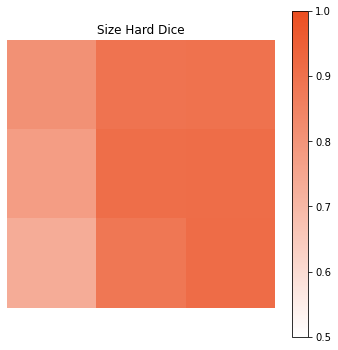

In [85]:
plt.figure(figsize=(6,6))
plt.imshow(conf_mat_size_hd, cmap=size_cmap)
plt.clim([0.5,1])
plt.colorbar()
plt.axis('off')
plt.title('Size Hard Dice')
plt.savefig('Figures/Paper/SI/HyperparameterSearch_Size_generalization_HD_ConfMat.eps')

# Qualitatively examine some of the models

For the 2.2nm models, the fold4 models perform relatively similarly between the hyperparameter-search model and the regular model (also, hyperparameter search is essentially done on the fold 4 dataset).

In [86]:
model_hp = torch.load('DH_4blck_FFCorr2p2nmAu/Best model/HS_2p2nmAu_model3_fold4_seed45521_model.h5')
model_reg = torch.load('Size generalization 330kX/UNet_2p2nmAu330kX423eUTC_fold4_seed45521_model.h5')

In [87]:
k_folds = 5
imgs_folds = np.array_split(img_2p2nm, k_folds)
lbls_folds = np.array_split(label_2p2nm, k_folds)

test_dataset = imgs_folds[4]
test_lbls = lbls_folds[4]
test_dataset, test_lbls = shuffle_Aug_PyTorch(test_dataset, test_lbls,7427)

test_Dataset = TEMImageDataset_Local_PartialRot(test_dataset,test_lbls, transform_flag = False)
test_dataloader = DataLoader(test_Dataset, batch_size=32, shuffle=True, num_workers=2)

In [88]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sample_batch = next(iter(test_dataloader))
with torch.no_grad():
    images = sample_batch['image'].to(device)
    labels = sample_batch['label'].to(device)
    pred_hp = model_hp(images)
    pred_reg = model_reg(images)
    sm_layer = nn.Softmax2d()
    pred_hp = sm_layer(pred_hp)
    pred_reg = sm_layer(pred_reg)

Hard Dice Scores for the Default Model predictions shown above:  tensor([0.8231, 0.7437, 0.8508], device='cuda:0')
Hard Dice Scores for the Hyperparameter Search Model predictions shown above:  tensor([0.8281, 0.7093, 0.8827], device='cuda:0')


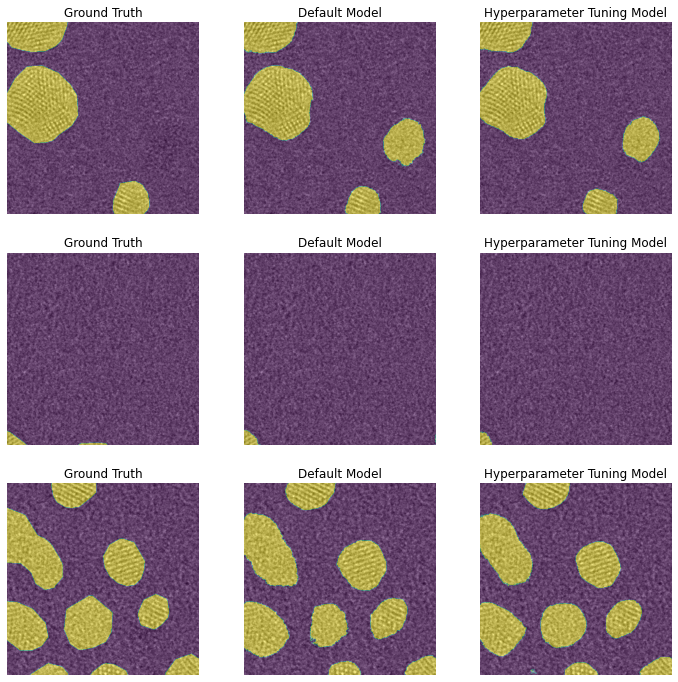

In [104]:
sample_num=25
plt.figure(figsize=(12,12))
for i in range(3):
    plt.subplot(3,3,3*i+1)
    plt.imshow(images[sample_num+i,0,:,:].detach().cpu().numpy(),vmin=-4,vmax=4,cmap='gray')
    plt.imshow(labels[sample_num+i,0,:,:].detach().cpu().numpy(),alpha=0.5)
    plt.axis('off')
    plt.title('Ground Truth')
    plt.subplot(3,3,3*i+2)
    plt.imshow(images[sample_num+i,0,:,:].detach().cpu().numpy(),vmin=-4,vmax=4,cmap='gray')
    plt.imshow(pred_reg[sample_num+i,1,:,:].detach().cpu().numpy()>0.5,alpha=0.5)
    plt.axis('off')
    plt.title('Default Model')
    plt.subplot(3,3,3*i+3)
    plt.imshow(images[sample_num+i,0,:,:].detach().cpu().numpy(),vmin=-4,vmax=4,cmap='gray')
    plt.imshow(pred_hp[sample_num+i,1,:,:].detach().cpu().numpy()>0.5,alpha=0.5)
    plt.axis('off')
    plt.title('Hyperparameter Tuning Model')

# Need to run the below cell first to have this print out correctly
print('Hard Dice Scores for the Default Model predictions shown above: ', hd_reg_sample_batch[sample_num:sample_num+3])
print('Hard Dice Scores for the Hyperparameter Search Model predictions shown above: ', hd_hp_sample_batch[sample_num:sample_num+3])

In [95]:
def compute_dice_hard_list(y_pred, y_truth, device1, smooth=1):
  #Need to first convert the ground truth into one-hot labels
  #Create a new one_hot tensor on the device
  one_hot = torch.zeros_like(y_pred, device=device1)
  one_hot.scatter_(1,y_truth,1) #first argument is dimension that needs to "expand", second is the indicies to go to, third is the value to place at those locations
  y_pred = torch.round(y_pred) #normalize the class score
  intersection = torch.sum(y_pred[:,1,:,:] * one_hot[:,1,:,:], dim=(1,2)) #elemental multiplication and then sum, but only for one of the predictions, gives a N-sized tensor
  return torch.div(2. * intersection + smooth , torch.sum(one_hot[:,1,:,:], dim=(1,2)) + torch.sum(y_pred[:,1,:,:],dim=(1,2)) + smooth)

In [97]:
hd_reg_sample_batch = compute_dice_hard_list(pred_reg, labels.type(torch.LongTensor).to(device), device, smooth=1)
hd_hp_sample_batch = compute_dice_hard_list(pred_hp, labels.type(torch.LongTensor).to(device), device, smooth=1)

In [98]:
print('Hard Dice Scores for the Default Model predictions shown above: ', hd_reg_sample_batch[sample_num:sample_num+3])
print('Hard Dice Scores for the Hyperparameter Search Model predictions shown above: ', hd_hp_sample_batch[sample_num:sample_num+3])

Hard Dice Scores for the Default Model predictions shown above:  tensor([0.8168, 0.9565, 0.8374], device='cuda:0')
Hard Dice Scores for the Hyperparameter Search Model predictions shown above:  tensor([0.8316, 0.9302, 0.8400], device='cuda:0')
